# TODO


* Check BF's and effect sizes using weaker/stronger priors (probably won't have any effect here, except maybe for max-d in mouse data with CoMs)
* Calculate BF's using ten independent fits (would take 10x time, only do when finalizing the paper submission)

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Delta$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# Contents

* [Preregistered analysis](#prereg)
  * [Mouse-tracking task](#mouse) 
    * [Max-d](#mouse_max_d)
    * [Response time](#mouse_RT)
  * [Walking task](#walking) 
    * [Max-d](#walking_max_d)
    * [Response time](#walking_RT)
* [Effect of changes-of-mind](#com)
  * [Mouse-tracking task](#com_mouse)
  * [Walking task](#com_walking)
* [Exploratory analysis](#explore)

In [1]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [2]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [3]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

# Checking for max-d unimodality<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [4]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.9655
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.837
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

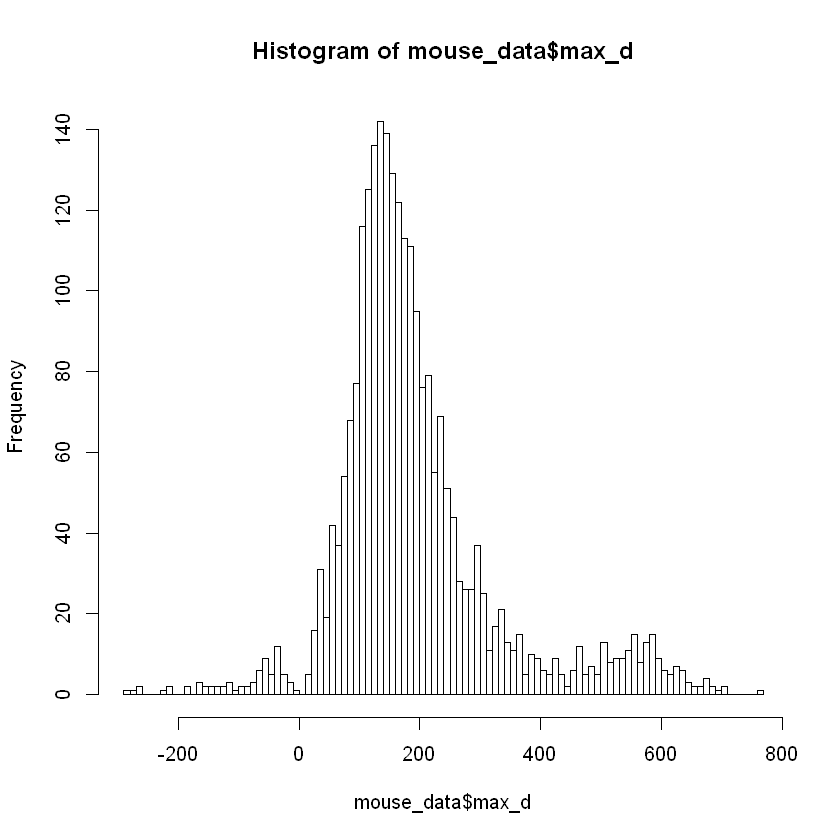

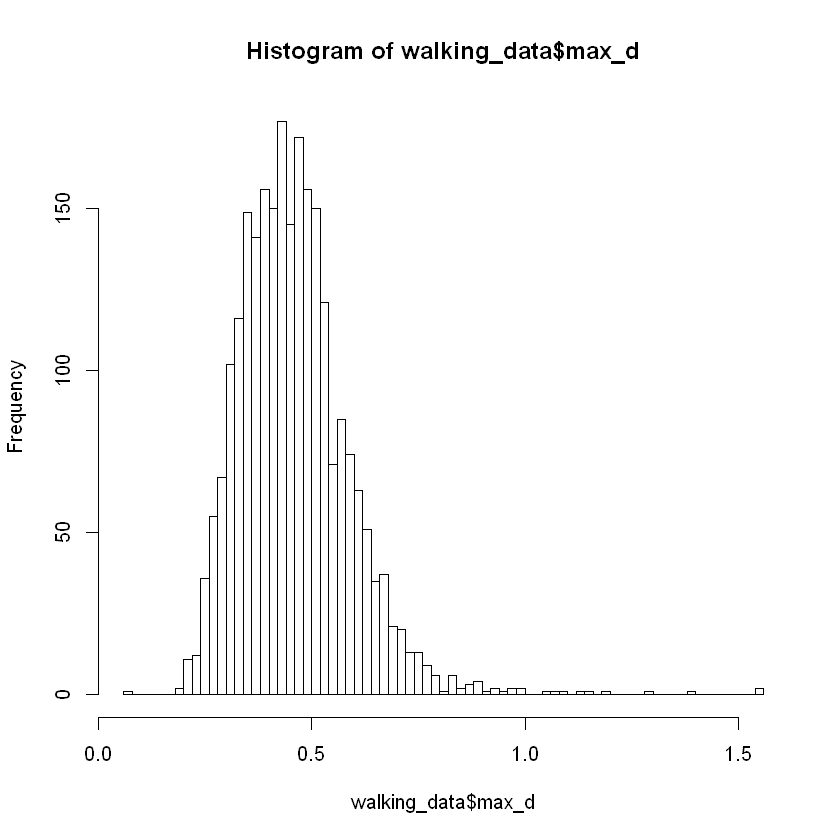

In [5]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [6]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

# Functions for model fitting and BF calculation

In [4]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter), ci_inter = ci_inter)
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
    }
    return(model)
}

run_analysis <- function(dv, iv, data, rscale){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv); rscale parameter defines the scale of prior distribution 
    on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    interaction_term = paste(iv, "option_chosen", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    analysis_id <- paste(dv, iv, deparse(substitute(data)))
    
    bf_result$analysis_id <- analysis_id    
#     print_bf(bf_result, analysis_id, iv)
    
    return(bf_result)
}

# Functions for visualizing and saving the results

In [9]:
print_bf <- function(bf_result, analysis_name, iv="Delta"){
    print(analysis_name)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_option_chosenll:", iv, sep=""), 
                         paste("b_option_chosenss:", iv, sep=""),
                         "b_option_chosenss"),]) 
#     print(bf_result$ci[c(paste("b_", iv, ":option_chosenll", sep=""), 
#                          paste("b_", iv, ":option_chosenss", sep="")),])

}

spaghetti_plot <- function(model, data, dv, iv, task, figure_format){
    file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format)
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300, 
                                 effects=paste(iv, "option_chosen", sep=":")), 
                plot=FALSE)[[1]]                                                                            
    plt <- plt + 
        geom_point(aes_string(x=iv, y=dv, shape='option_chosen', colour='option_chosen'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 24) +
        ggtitle(paste(task, gsub("_", "-", dv))) +
#         labs(fill = "choice") +
#         guides(fill=guide_legend(title="choice"))
        theme(plot.title = element_text(hjust = 0.5, size=24, face="plain")) +
        xlab(TeX("$\\Delta$")) +
        ylab(gsub("_", "-", dv)) +
        theme(legend.position="none") +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    if ((dv == 'RT') & (task == 'walking')){   
        plt <- plt + theme(legend.position = c(0.9, 0.9), 
                           legend.key.size = unit(24, "points"),
                           legend.title = element_blank(),
                           legend.text = element_text(size=24),
                           legend.key = element_rect(colour = "transparent", fill = "white")) 
#         guides(color=guide_legend(override.aes=list(fill=NA)), fill=guide_legend(title="choice"))
#         plt <- plt + guides(linetype = guide_legend(override.aes = list(size = 10)))
    }
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4) 
}

joyplot <- function(model, file_name){
    m <- as.matrix(as.mcmc(model, combine_chains = FALSE))

    # Only keep the choice-by-lambda interaction parameters    
    m <- m[,grep(",option_chosen", colnames(m))]
    
    # Reformat column names
    colnames(m) <- sub("r_subj_id\\[", "s", colnames(m))
    colnames(m) <- sub(",option_chosenss]", "", colnames(m))
    
    # Reorder columns(parameters) by their mean values and plot the result        
    plt <- mcmc_areas_ridges(m[,order(colMeans(m))])#, prob=0.95)
    
    plt <- plt + theme_pander(base_size = 12) +
        xlab("Offset of regression coefficient for SS choices") #+
#         scale_color_manual(values = c("#D55E00", "#0072B2"), guide = "none")
#     +
#        scale_color_viridis(discrete=TRUE, alpha=0.4, begin=0.0, end=0.7)
    ggsave(file.path(figure_path, file_name), dpi=150, width=4, height=8)
}

posterior_plot <- function(model, iv, file_name){
    plot <- mcmc_areas_ridges(as.matrix(as.mcmc(model, combine_chains = TRUE)), 
                              regex_pars = paste("b_", iv, ":option_chosen", sep=""), prob=0.95)
    ggsave(file.path(figure_path, file_name), dpi=150, width=8, height=4)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", file_name), row.names=FALSE)
}

visualize_model <- function(model, data, task, dv, iv, figure_format){
    spaghetti_plot(model, data, dv, iv, task, figure_format)
    joyplot(model, file_name=sprintf("joy_%s_%s.%s", task, dv, figure_format))
    save_posterior(model, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
#     posterior_plot(model, iv, file_name=sprintf("posterior_%s_%s.%s", task, dv, figure_format))
}

# Functions for aggregating the results

In [6]:
save_all_plots <- function(results, iv){
    visualize_model(results$mouse_max_d_bf$models$m_inter, mouse_data, "mouse", "max_d", iv, figure_format)
    visualize_model(results$mouse_rt_bf$models$m_inter, mouse_data, "mouse", "RT", iv, figure_format)
    visualize_model(results$walking_max_d_bf$models$m_inter, walking_data, "walking", "max_d", iv, figure_format)
    visualize_model(results$walking_rt_bf$models$m_inter, walking_data, "walking", "RT", iv, figure_format)
    visualize_model(results$mouse_max_d_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    visualize_model(results$walking_max_d_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    visualize_model(results$walking_rt_no_com_bf$models$m_inter, walking_data_no_com, 
                    "walking_no_com", "RT", iv, figure_format)    
    visualize_model(results$mouse_rt_no_com_bf$models$m_inter, mouse_data_no_com, 
                    "mouse_no_com", "RT", iv, figure_format)
}

print_all_bfs <- function(results, iv){
    print_bf(results$mouse_max_d_bf, "mouse task max-d analysis", iv)
    print_bf(results$mouse_rt_bf, "mouse task RT analysis", iv)
    print_bf(results$walking_max_d_bf, "walking task max-d analysis", iv)
    print_bf(results$walking_rt_bf, "walking task RT analysis", iv)    

    print_bf(results$mouse_max_d_no_com_bf, "mouse task max-d no CoM analysis", iv)
    print_bf(results$mouse_rt_no_com_bf, "mouse task RT no CoM analysis", iv)
    print_bf(results$walking_max_d_no_com_bf, "walking task max-d no CoM analysis", iv)
    print_bf(results$walking_rt_no_com_bf, "walking task RT no CoM analysis", iv)    
}

run_all_analyses <- function(iv, rscale){
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, rscale)
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, rscale)
    
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, rscale)
    walking_rt_bf <- run_analysis("RT", iv, walking_data, rscale)
    
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, rscale)        
    mouse_rt_no_com_bf <- run_analysis("RT", iv, mouse_data_no_com, rscale)    
    
    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, rscale)
    walking_rt_no_com_bf <- run_analysis("RT", iv, walking_data_no_com, rscale)
        
    return(list(mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf, 
                walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_no_com_bf = mouse_max_d_no_com_bf, mouse_rt_no_com_bf = mouse_rt_no_com_bf,
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, walking_rt_no_com_bf = walking_rt_no_com_bf))
}

# Run analyses (takes a lot of time!)

In [7]:
lambda_results <- run_all_analyses("Lambda", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.941 seconds (Warm-up)
               11.743 seconds (Sampling)
               35.684 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.616 seconds (Warm-up)
               12.274 seconds (Sampling)
               35.89 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.645 seconds (Warm-up)
               16.596 seconds (Sampling)
               39.241 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.219

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.828 seconds (Warm-up)
               10.809 seconds (Sampling)
               31.637 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.513 seconds (Warm-up)
               15.002 seconds (Sampling)
               33.515 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.192 seconds (Warm-up)
               17.83 seconds (Sampling)
               44.022 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.886

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.532 seconds (Warm-up)
               4.926 seconds (Sampling)
               11.458 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.923 seconds (Warm-up)
               5.267 seconds (Sampling)
               11.19 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.268 seconds (Warm-up)
               4.531 seconds (Sampling)
               11.799 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.151 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.312 seconds (Warm-up)
               19.493 seconds (Sampling)
               46.805 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.616 seconds (Warm-up)
               20.219 seconds (Sampling)
               52.835 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.117 seconds (Warm-up)
               21.29 seconds (Sampling)
               53.407 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.796

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.548 seconds (Warm-up)
               16.367 seconds (Sampling)
               39.915 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.433 seconds (Warm-up)
               18.08 seconds (Sampling)
               39.513 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.72 seconds (Warm-up)
               15.11 seconds (Sampling)
               36.83 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.094 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.084 seconds (Warm-up)
               4.219 seconds (Sampling)
               8.303 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.92 seconds (Warm-up)
               2.456 seconds (Sampling)
               6.376 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.688 seconds (Warm-up)
               4.888 seconds (Sampling)
               9.576 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.486 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 57.595 seconds (Warm-up)
               27.414 seconds (Sampling)
               85.009 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 51.657 seconds (Warm-up)
               24.621 seconds (Sampling)
               76.278 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 47.168 seconds (Warm-up)
               16.293 seconds (Sampling)
               63.461 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elap

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.605 seconds (Warm-up)
               26.409 seconds (Sampling)
               65.014 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.136 seconds (Warm-up)
               26.369 seconds (Sampling)
               65.505 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.524 seconds (Warm-up)
               13.878 seconds (Sampling)
               45.402 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.405 seconds (Warm-up)
               3.594 seconds (Sampling)
               13.999 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 11.388 seconds (Warm-up)
               6.605 seconds (Sampling)
               17.993 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 12.027 seconds (Warm-up)
               3.667 seconds (Sampling)
               15.694 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 42.132 seconds (Warm-up)
               24.836 seconds (Sampling)
               66.968 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 49.404 seconds (Warm-up)
               35.002 seconds (Sampling)
               84.406 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 47.16 seconds (Warm-up)
               32.135 seconds (Sampling)
               79.295 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 43.054

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.011 seconds (Warm-up)
               22.016 seconds (Sampling)
               57.027 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.817 seconds (Warm-up)
               23.978 seconds (Sampling)
               58.795 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.881 seconds (Warm-up)
               21.249 seconds (Sampling)
               58.13 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.519

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.264 seconds (Warm-up)
               4.452 seconds (Sampling)
               9.716 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.89 seconds (Warm-up)
               8.115 seconds (Sampling)
               14.005 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.235 seconds (Warm-up)
               4.173 seconds (Sampling)
               9.408 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.923 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.865 seconds (Warm-up)
               14.423 seconds (Sampling)
               37.288 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.156 seconds (Warm-up)
               14.031 seconds (Sampling)
               39.187 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.579 seconds (Warm-up)
               13.363 seconds (Sampling)
               49.942 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.33

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.116 seconds (Warm-up)
               14.369 seconds (Sampling)
               35.485 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 43.698 seconds (Warm-up)
               780.024 seconds (Sampling)
               823.722 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.287 seconds (Warm-up)
               11.767 seconds (Sampling)
               42.054 seconds (Total)


Gradient evaluation took 0.015 seconds
1000 transitions using 10 leapfrog steps per transition would take 150 seconds.
Adjust your expectations accordingly!



 Elapsed Tim

Compiling the C++ model
Start sampling



Gradient evaluation took 0.015 seconds
1000 transitions using 10 leapfrog steps per transition would take 150 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 13.212 seconds (Warm-up)
               7.417 seconds (Sampling)
               20.629 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 12.703 seconds (Warm-up)
               10.681 seconds (Sampling)
               23.384 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 15.564 seconds (Warm-up)
               10.649 seconds (Sampling)
               26.213 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 65.741 seconds (Warm-up)
               30.677 seconds (Sampling)
               96.418 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 61.559 seconds (Warm-up)
               35.264 seconds (Sampling)
               96.823 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 65.825 seconds (Warm-up)
               47.61 seconds (Sampling)
               113.435 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 62.86

Compiling the C++ model
Start sampling



Gradient evaluation took 0.016 seconds
1000 transitions using 10 leapfrog steps per transition would take 160 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 69.968 seconds (Warm-up)
               38.676 seconds (Sampling)
               108.644 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 51.875 seconds (Warm-up)
               31.966 seconds (Sampling)
               83.841 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 52.735 seconds (Warm-up)
               25.236 seconds (Sampling)
               77.971 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 12.185 seconds (Warm-up)
               10.144 seconds (Sampling)
               22.329 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.725 seconds (Warm-up)
               5.421 seconds (Sampling)
               16.146 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.27 seconds (Warm-up)
               10.81 seconds (Sampling)
               21.08 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 10.974 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.93 seconds (Warm-up)
               14.878 seconds (Sampling)
               55.808 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.557 seconds (Warm-up)
               22.078 seconds (Sampling)
               61.635 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 42.453 seconds (Warm-up)
               22.594 seconds (Sampling)
               65.047 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 55.532

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.765 seconds (Warm-up)
               13.657 seconds (Sampling)
               42.422 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.345 seconds (Warm-up)
               18.765 seconds (Sampling)
               51.11 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.422 seconds (Warm-up)
               14.343 seconds (Sampling)
               49.765 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.986

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.014 seconds (Warm-up)
               4.251 seconds (Sampling)
               11.265 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.547 seconds (Warm-up)
               5.406 seconds (Sampling)
               13.953 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.516 seconds (Warm-up)
               2.281 seconds (Sampling)
               9.797 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.515 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.751 seconds (Warm-up)
               21.781 seconds (Sampling)
               57.532 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.203 seconds (Warm-up)
               22.266 seconds (Sampling)
               58.469 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.594 seconds (Warm-up)
               21.782 seconds (Sampling)
               62.376 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.23

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.938 seconds (Warm-up)
               20.408 seconds (Sampling)
               53.346 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.14 seconds (Warm-up)
               21.14 seconds (Sampling)
               54.28 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.374 seconds (Warm-up)
               20.391 seconds (Sampling)
               49.765 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.25 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.563 seconds (Warm-up)
               3.985 seconds (Sampling)
               9.548 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.282 seconds (Warm-up)
               4.578 seconds (Sampling)
               10.86 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.077 seconds (Warm-up)
               4.781 seconds (Sampling)
               9.858 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.469 seconds 

In [34]:
delta_results <- run_all_analyses("Delta", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.705 seconds (Warm-up)
               12.44 seconds (Sampling)
               33.145 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.961 seconds (Warm-up)
               11.603 seconds (Sampling)
               34.564 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.435 seconds (Warm-up)
               20.38 seconds (Sampling)
               42.815 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.424 seconds (Warm-up)
               11.626 seconds (Sampling)
               34.05 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.717 seconds (Warm-up)
               13.615 seconds (Sampling)
               40.332 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.509 seconds (Warm-up)
               13.119 seconds (Sampling)
               30.628 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.328 seconds (Warm-up)
               2.17 seconds (Sampling)
               8.498 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.122 seconds (Warm-up)
               2.391 seconds (Sampling)
               7.513 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.553 seconds (Warm-up)
               4.119 seconds (Sampling)
               8.672 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.738 seco

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.863 seconds (Warm-up)
               13.124 seconds (Sampling)
               34.987 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.981 seconds (Warm-up)
               12.018 seconds (Sampling)
               33.999 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.786 seconds (Warm-up)
               13.373 seconds (Sampling)
               35.159 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.48 seconds (Warm-up)
               13.674 seconds (Sampling)
               33.154 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.15 seconds (Warm-up)
               16.087 seconds (Sampling)
               36.237 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.891 seconds (Warm-up)
               10.823 seconds (Sampling)
               32.714 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.119 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.727 seconds (Warm-up)
               4.294 seconds (Sampling)
               9.021 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.555 seconds (Warm-up)
               4.293 seconds (Sampling)
               8.848 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.855 seconds (Warm-up)
               3.642 seconds (Sampling)
               7.497 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.338 sec

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.314 seconds (Warm-up)
               21.444 seconds (Sampling)
               54.758 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.96 seconds (Warm-up)
               16.368 seconds (Sampling)
               46.328 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.231 seconds (Warm-up)
               17.199 seconds (Sampling)
               45.43 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Tim

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.186 seconds (Warm-up)
               11.639 seconds (Sampling)
               40.825 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.388 seconds (Warm-up)
               13.135 seconds (Sampling)
               37.523 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.23 seconds (Warm-up)
               11.249 seconds (Sampling)
               39.479 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.111

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.171 seconds (Warm-up)
               4.249 seconds (Sampling)
               11.42 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.855 seconds (Warm-up)
               2.313 seconds (Sampling)
               9.168 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.742 seconds (Warm-up)
               4.327 seconds (Sampling)
               11.069 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.202 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.506 seconds (Warm-up)
               22.305 seconds (Sampling)
               53.811 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.619 seconds (Warm-up)
               21.892 seconds (Sampling)
               53.511 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.913 seconds (Warm-up)
               27.561 seconds (Sampling)
               61.474 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.411 seconds (Warm-up)
               21.57 seconds (Sampling)
               50.981 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.64 seconds (Warm-up)
               20.772 seconds (Sampling)
               53.412 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.848 seconds (Warm-up)
               20.993 seconds (Sampling)
               50.841 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.9 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.741 seconds (Warm-up)
               4.687 seconds (Sampling)
               10.428 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.369 seconds (Warm-up)
               7.411 seconds (Sampling)
               12.78 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.615 seconds (Warm-up)
               4.105 seconds (Sampling)
               8.72 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.7 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.029 seconds (Warm-up)
               19.769 seconds (Sampling)
               45.798 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.833 seconds (Warm-up)
               18.78 seconds (Sampling)
               46.613 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.675 seconds (Warm-up)
               18.123 seconds (Sampling)
               46.798 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.408 seconds (Warm-up)
               19.059 seconds (Sampling)
               41.467 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.542 seconds (Warm-up)
               19.069 seconds (Sampling)
               46.611 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.245 seconds (Warm-up)
               17.125 seconds (Sampling)
               39.37 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.407

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.476 seconds (Warm-up)
               4.049 seconds (Sampling)
               9.525 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.089 seconds (Warm-up)
               4.154 seconds (Sampling)
               9.243 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.541 seconds (Warm-up)
               4.005 seconds (Sampling)
               9.546 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.79 seco

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.021 seconds (Warm-up)
               19.796 seconds (Sampling)
               40.817 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.66 seconds (Warm-up)
               15.181 seconds (Sampling)
               35.841 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.188 seconds (Warm-up)
               13.827 seconds (Sampling)
               36.015 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.339 seconds (Warm-up)
               9.85 seconds (Sampling)
               30.189 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.47 seconds (Warm-up)
               16.606 seconds (Sampling)
               36.076 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.754 seconds (Warm-up)
               17.006 seconds (Sampling)
               36.76 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 17.5

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.921 seconds (Warm-up)
               4.063 seconds (Sampling)
               7.984 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.353 seconds (Warm-up)
               3.063 seconds (Sampling)
               7.416 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.63 seconds (Warm-up)
               3.024 seconds (Sampling)
               6.654 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.792 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.001 seconds (Warm-up)
               16.494 seconds (Sampling)
               50.495 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.635 seconds (Warm-up)
               17.007 seconds (Sampling)
               48.642 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.836 seconds (Warm-up)
               27.122 seconds (Sampling)
               58.958 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.07

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.247 seconds (Warm-up)
               12.812 seconds (Sampling)
               51.059 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.75 seconds (Warm-up)
               20.592 seconds (Sampling)
               50.342 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.085 seconds (Warm-up)
               23.69 seconds (Sampling)
               55.775 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Tim

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.569 seconds (Warm-up)
               3.011 seconds (Sampling)
               9.58 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.553 seconds (Warm-up)
               3.724 seconds (Sampling)
               11.277 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.659 seconds (Warm-up)
               4.229 seconds (Sampling)
               11.888 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.513 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.86 seconds (Warm-up)
               22.067 seconds (Sampling)
               56.927 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.304 seconds (Warm-up)
               21.99 seconds (Sampling)
               54.294 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.004 seconds (Warm-up)
               22.403 seconds (Sampling)
               56.407 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Tim

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.026 seconds (Warm-up)
               21.346 seconds (Sampling)
               53.372 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.078 seconds (Warm-up)
               22.134 seconds (Sampling)
               52.212 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.686 seconds (Warm-up)
               20.572 seconds (Sampling)
               54.258 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.008 seconds (Warm-up)
               4.31 seconds (Sampling)
               9.318 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.631 seconds (Warm-up)
               4.301 seconds (Sampling)
               9.932 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.227 seconds (Warm-up)
               4.444 seconds (Sampling)
               9.671 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.037 seconds (

In [ ]:
delta_results_narrow_priors <- run_all_analyses("Delta", rscale=0.5)

In [ ]:
delta_results_wide_priors <- run_all_analyses("Delta", rscale=1.0)

Compiling the C++ model


# Print Bayes factors

In [8]:
print_all_bfs(lambda_results, "Lambda")

[1] "mouse task max-d analysis"
[1] "BF of choice model over null model: 8.20672e+76"
[1] "BF of choice-by-delta model over null model: 9.56372e+77"
[1] "BF of choice-by-delta model over choice-only model: 14.094"
                               lower      upper
b_option_chosenll:Lambda  -14.121583  -6.678960
b_option_chosenss:Lambda   -1.381244   5.275248
b_option_chosenss        -102.958072 -31.958205
[1] "mouse task RT analysis"
[1] "BF of choice model over null model: 3.97482e+10"
[1] "BF of choice-by-delta model over null model: 6.71253e+34"
[1] "BF of choice-by-delta model over choice-only model: 1.72385e+24"
                               lower      upper
b_option_chosenll:Lambda -0.19140427 -0.1245902
b_option_chosenss:Lambda  0.07798471  0.1375919
b_option_chosenss        -1.29638928 -0.8809797
[1] "walking task max-d analysis"
[1] "BF of choice model over null model: 3.64763e+66"
[1] "BF of choice-by-delta model over null model: 1.13628e+78"
[1] "BF of choice-by-delta model ov

In [91]:
print_all_bfs(delta_results, "Delta")

[1] "mouse task max-d analysis"
[1] "BF of choice model over null model: 6.69943e+76"
[1] "BF of choice-by-delta model over null model: 6.87492e+82"
[1] "BF of choice-by-delta model over choice-only model: 1.18178e+06"
                             lower      upper
b_option_chosenll:Delta -104.31988 -45.410833
b_option_chosenss:Delta   32.38403  67.152680
b_option_chosenss        -50.58378   8.392398
[1] "mouse task RT analysis"
[1] "BF of choice model over null model: 3.52768e+10"
[1] "BF of choice-by-delta model over null model: 6.51843e+46"
[1] "BF of choice-by-delta model over choice-only model: 1.8567e+36"
                             lower       upper
b_option_chosenll:Delta -1.5182085 -1.00576418
b_option_chosenss:Delta  0.6332761  0.93284364
b_option_chosenss       -0.2938039 -0.03487499
[1] "walking task max-d analysis"
[1] "BF of choice model over null model: 4.09382e+66"
[1] "BF of choice-by-delta model over null model: 3.82257e+81"
[1] "BF of choice-by-delta model over choic

# Save plots

In [11]:
save_all_plots(lambda_results, "Lambda")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [82]:
save_all_plots(delta_results, "Delta")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Generate tables with Bayes factors

In [83]:
save_bf_table <- function(results, caption, label, file_name){
    hyp_1_format_string <- "\\begin{table}[]
                            \\caption{%s}
                            \\label{%s}
                            \\begin{tabular}{@{}llll@{}}
                            \\toprule
                             &  & max-d & RT \\\\ \\midrule
                            \\multirow{2}{*}{walking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded &  \\num{%g} & \\num{%g} \\\\
                            \\multirow{2}{*}{mouse-tracking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded & \\num{%g} & \\num{%g} \\\\ \\cmidrule(l){1-4} 
                            \\end{tabular}
                            \\end{table}"
    
    output <- sprintf(hyp_1_format_string, caption, label, 
                      results$walking_max_d_bf$bf[3], results$walking_rt_bf$bf[3],
                      results$walking_max_d_no_com_bf$bf[3], results$walking_rt_no_com_bf$bf[3],
                      results$mouse_max_d_bf$bf[3], results$mouse_rt_bf$bf[3],
                      results$mouse_max_d_no_com_bf$bf[3], results$mouse_rt_no_com_bf$bf[3])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

In [84]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_delta"
file_name = "hyp_1_bf_delta.tex"

save_bf_table(delta_results, caption, label, file_name)

In [8]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_lambda"
file_name = "hyp_1_bf_lambda.tex"

save_bf_table(lambda_results, caption, label, file_name)

# Save coefficients 

In [4]:
m <- as.mcmc(delta_results$mouse_max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_walking.csv")

m <- as.mcmc(delta_results$mouse_rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_coeffs_mouse.csv")

# Save all results to RData file

In [110]:
save.image()